# Convolutional neural networks
This notebook uses the hybridmodels-modelbuild virtual environment.

In [137]:
from os.path import join
import glob

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

In [222]:
wd = join("..", "data", "indata_new")
features = ['storm', 'region', 'subregion', 'floodfrac', 'gebco', 'fabdem',
            'jrc_permwa', 'elevation', 'soilcarbon', 'mangrove', 'ndvi', 'wind_avg',
           "geometry"]

# load all data as one geodataframe
l = [gpd.read_file(filename) for filename in glob.glob(join(wd, "feature_stats", "*.shp"))]
gdf = pd.concat(l, axis=0)
gdf = gdf[features]

gdf["event"] = gdf["storm"] + "_" + gdf["region"] + "_" + gdf["subregion"].astype(str)
gdf = gdf.drop(["storm", "region", "subregion"], axis=1).reset_index(drop=True)
features.remove("storm")
features.remove("region")
features.remove("subregion")

TypeError: bad operand type for unary -: 'list'

### Process data into suitable shapes

In [252]:
# get dimensions to create node feature matrices for grid
def get_rows_and_cols(df, gridsize=1000):
    from shapely.geometry import box
    df_pm = df.to_crs("EPSG:3857")
    bbounds = df_pm.total_bounds
    width = bbounds[2] - bbounds[0]
    height = bbounds[3] - bbounds[1]
    nrows = int(np.round(height / gridsize, 0))
    ncols = int(np.round(width  / gridsize, 0))
    return nrows, ncols

def reshape_df(df, nrows, ncols, features):
    df = df.drop("geometry", axis=1)
    n = features[:]
    n.remove('geometry')
    feature_mat = np.empty(shape=(nrows, ncols, len(n)), dtype="float")
    for i, feature in enumerate(n):
        feature_arr = df[feature].values.reshape(nrows, ncols, order="F")
        feature_mat[:, :, i] = feature_arr
    return feature_mat

# code to reshape features into tensors
mats = {}
areas = {}
shapes = {}
for event in [*gdf["event"].unique()]:

    df = gdf[gdf["event"] == event]
    nrows, ncols = get_rows_and_cols(df)
    print(f"nrows:{nrows}, ncols: {ncols}")
    shapes[event] = (nrows, ncols)
    areas[event] = nrows * ncols
    mats[event] = reshape_df(df, nrows, ncols, features)

nrows:49, ncols: 82
nrows:55, ncols: 78
nrows:16, ncols: 23
nrows:7, ncols: 13
nrows:6, ncols: 10
nrows:8, ncols: 17
nrows:13, ncols: 19


In [261]:
shapes

{'gombe_mossuril_0': (49, 82),
 'gombe_mossuril_1': (55, 78),
 'emnati_vohipeno_0': (16, 23),
 'emnati_vohipeno_1': (7, 13),
 'emnati_farafangana_0': (6, 10),
 'emnati_namorona_0': (8, 17),
 'emnati_manakara_0': (13, 19)}

In [253]:
biggest = max(areas, key=areas.get)
shape = shapes[biggest]
padding = np.zeros(shape)

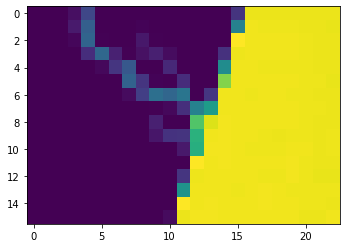

In [264]:
mat = mats['emnati_vohipeno_0'][:, :, 3]

plt.imshow(mat)

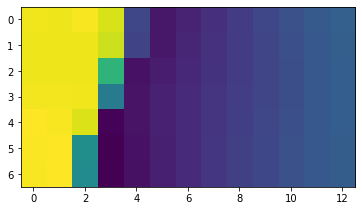

In [256]:
plt.imshow(mats['emnati_vohipeno_1'][:, :, 1])

In [248]:
padding

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

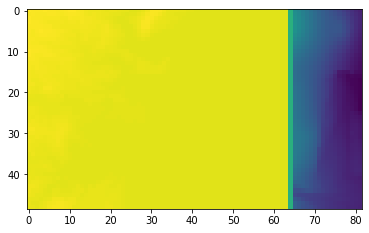

In [213]:
plt.imshow(new[:, :, 4])

In [98]:
# split gdf based on "event"...

,floodfrac,gebco,fabdem,jrc_permwa,elevation,soilcarbon,mangrove,ndvi,wind_avg,geometry,event
0,0.000000,124.292151,125.917610,0.000000,125.917610,3.480803,0.0,7033.752470,5.903529,"POLYGON ((40.42419 -14.83067, 40.43318 -14.830...",gombe_mossuril_0
1,0.018276,111.927987,110.513420,0.000000,110.513420,3.249564,0.0,6809.877567,5.933966,"POLYGON ((40.42419 -14.83935, 40.43318 -14.839...",gombe_mossuril_0
2,0.000000,126.247839,123.275932,0.000000,123.275932,3.759983,0.0,6769.984298,5.964638,"POLYGON ((40.42419 -14.84803, 40.43318 -14.848...",gombe_mossuril_0
3,0.000000,130.902395,125.910583,0.000000,125.910583,2.963327,0.0,6895.865272,5.995539,"POLYGON ((40.42419 -14.85672, 40.43318 -14.856...",gombe_mossuril_0
4,0.000000,123.014504,119.161812,0.000000,119.161812,3.642436,0.0,6665.018666,6.026656,"POLYGON ((40.42419 -14.86540, 40.43318 -14.865...",gombe_mossuril_0
...,...,...,...,...,...,...,...,...,...,...,...
242,0.000000,-32.550631,0.000000,97.361114,0.000000,0.000000,0.0,0.000000,4.194179,"POLYGON ((48.10672 -22.18465, 48.11570 -22.184...",emnati_manakara_0
243,0.000000,-34.212151,0.000000,97.708305,0.000000,0.000000,0.0,0.000000,4.192184,"POLYGON ((48.10672 -22.19297, 48.11570 -22.192...",emnati_manakara_0
244,0.000000,-36.202415,0.000000,98.068685,0.000000,0.000000,0.0,0.000000,4.190195,"POLYGON ((48.10672 -22.20129, 48.11570 -22.201...",emnati_manakara_0
245,0.000000,-38.204062,0.000000,97.634542,0.000000,0.000000,0.0,0.000000,4.188211,"POLYGON ((48.10672 -22.20960, 48.11570 -22.209...",emnati_manakara_0


## Simple FCN
### [(Long 2020)](https://github.com/giovanniguidi/FCN-keras/tree/master/models) and [Stanford Lecture](https://www.youtube.com/watch?v=nDPWywWRIRo)
#### Simplest model
* set all features with mask==1 to 0 and use zero padding
* mask all input images to the same size with zero padding

#### Future extensions
1. [ ] partialconv padding
2. [x] fully convolutional for variable image sizes
3. [ ] certain image dimensions needed for encoder-decoder?
4. [ ] dilation to layers

In [294]:
from keras import Sequential
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD

In [45]:
# normalise data

In [ ]:
# https://github.com/keras-team/keras/issues/1920
# https://groups.google.com/g/keras-users/c/cPogZ6yhovQ/m/gBEZqnbxEwAJ

In [296]:
# build model with encoder-decoder architecture
conv2D = Sequential(name="FloodFraction_Conv2D")
conv2D.add(Input(shape=(None, None, 10)))

# convolution
# high res block
conv2D.add(Conv2D(filters=64, padding="same", kernel_size=(3, 3), activation='relu', name="C1"))
conv2D.add(MaxPooling2D(pool_size=(3, 3), padding='valid', name='Encode1'))
           
# med res blocks
conv2D.add(Conv2D(filters=128, padding="same", kernel_size=(3, 3), activation='relu', name="D1"))
conv2D.add(Conv2D(filters=128, padding="same", kernel_size=(3, 3), activation='relu', name="D2"))
conv2D.add(Conv2D(filters=128, padding="same", kernel_size=(3, 3), activation='relu', name="D3"))
conv2D.add(MaxPooling2D(pool_size=(3, 3), padding='valid', name='Encode2'))

# low res blocks
conv2D.add(Conv2D(filters=256, padding="same", kernel_size=(3, 3), activation='relu', name="E1"))
conv2D.add(Conv2D(filters=256, padding="same", kernel_size=(3, 3), activation='relu', name="E2"))

# transpose convolution back to medium res 
conv2D.add(Conv2DTranspose(128, kernel_size=(3, 3), strides=(3, 3), padding="valid", name="Decode1"))
conv2D.add(Conv2D(filters=128, padding="same", kernel_size=(3, 3), activation='relu', name="F1"))
conv2D.add(Conv2D(filters=128, padding="same", kernel_size=(3, 3), activation='relu', name="F2"))

# transpose convolution back to high res
conv2D.add(Conv2DTranspose(10, kernel_size=(3, 3), strides=(3, 3), padding="valid", name="Decode2"))
conv2D.add(Conv2D(filters=64, padding="same", kernel_size=(3, 3), activation='relu', name="G1"))
conv2D.add(Conv2D(filters=1, padding="same", kernel_size=(3, 3), activation='relu', name="G2"))

# view output shape
conv2D.output_shape  # (batch, dim1, dim2, nchannels)

(None, None, None, 1)

In [297]:
optimizer = SGD(learning_rate=0.01)

conv2D.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
conv2D.summary()

Model: "FloodFraction_Conv2D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, None, None, 64)    5824      
                                                                 
 Encode1 (MaxPooling2D)      (None, None, None, 64)    0         
                                                                 
 D1 (Conv2D)                 (None, None, None, 128)   73856     
                                                                 
 D2 (Conv2D)                 (None, None, None, 128)   147584    
                                                                 
 D3 (Conv2D)                 (None, None, None, 128)   147584    
                                                                 
 Encode2 (MaxPooling2D)      (None, None, None, 128)   0         
                                                                 
 E1 (Conv2D)                 (None, None, None